In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
import zookeeper as zk
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('spada e s' + str(device))

mappy = False ### if the Net isn't mapped
rgb = False

spada e scuda


In [3]:
class GalaxyNet(nn.Module):
    def __init__(self, activation, initialization=False, mappy=False, is_rgb=False):
        super().__init__()
        
        self.mappy = mappy
        rgb = 3 if is_rgb else 1
        input_size = 128
        num_labels = 37
        self.loss_dict = {'batch' : [], 'epoch' : [], 'vbatch' : [], 'vepoch' : []}
        self.activation = activation
        
        self.convs = nn.Sequential(
            nn.Conv2d(rgb, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 16, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(16),
            
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 3, padding='same', bias=False),
            self.activation(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, bias=False),
            self.activation(),
            nn.BatchNorm2d(256),

            nn.MaxPool2d(2)
            )

        for layer in self.convs:
            if layer.__class__.__name__ == 'Conv2d': input_size = zk.convool_size(input_size, 3, 1, 'same' if layer.padding == 'same' else 0)
            elif layer.__class__.__name__ == 'MaxPool2d': input_size = zk.convool_size(input_size, 2, 2)

        if input_size < 2: raise ValueError('You shrank too much dude.')
        print(f'Convs output size: {input_size}')

        input_linear = 256 * input_size * input_size
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_linear, 100),
            self.activation(),
            nn.Linear(100, num_labels)
            )
        
        if initialization: self.init_weights()


    def forward(self, x):
        x = self.convs(x)
        x = self.fc(x)
        if self.mappy: x = zk.mappy2D(x)
        return x


    def init_weights(self):
        if self.activation == nn.ReLU:
            nonlin = 'relu'
            a = 0
        elif self.activation == nn.LeakyReLU:
            nonlin = 'leaky_relu'
            a = .01
        
        for layer in self.convs: 
            if layer.__class__.__name__ == 'Conv2d': nn.init.kaiming_normal_(layer.weight, a=a, nonlinearity=nonlin)        

        for i in (1, -1): nn.init.constant_(self.fc[i].bias, 0)
 
        nn.init.kaiming_normal_(self.fc[1].weight, a=a, nonlinearity=nonlin)
        nn.init.xavier_uniform_(self.fc[-1].weight)      
        

    def log_the_loss(self, item,epoch=False):
        train = self.__getstate__()['training']
        if epoch and train:
            self.loss_dict['epoch'].append(item)
        elif not epoch and train:
            self.loss_dict['batch'].append(item)
        elif not train and epoch:
            self.loss_dict['vepoch'].append(item)
        elif not train and not epoch:
            self.loss_dict['vbatch'].append(item)
        return item


In [4]:
model = GalaxyNet(nn.LeakyReLU, initialization=False, mappy=False, is_rgb=False).to(device)
loss_function = nn.MSELoss()
loader = torch.load('model_optim_110.pt', weights_only=True)
model.load_state_dict(loader['model_state_dict'])

Convs output size: 2


<All keys matched successfully>

In [5]:
#get activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu()
    return hook

#plot feature maps
def plot_feature_maps(feature_map, n_cols=16, title="Feature Maps"):
    num_maps = feature_map.shape[1]
    n_rows = (num_maps + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for i in range(num_maps):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(feature_map[0, i], cmap='inferno')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

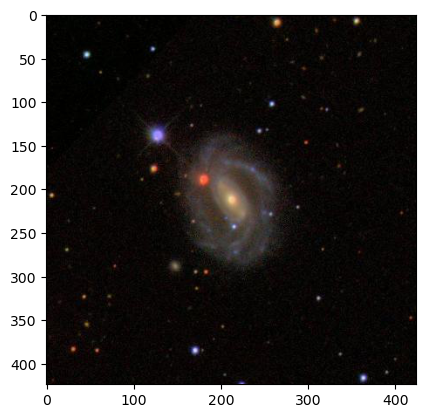

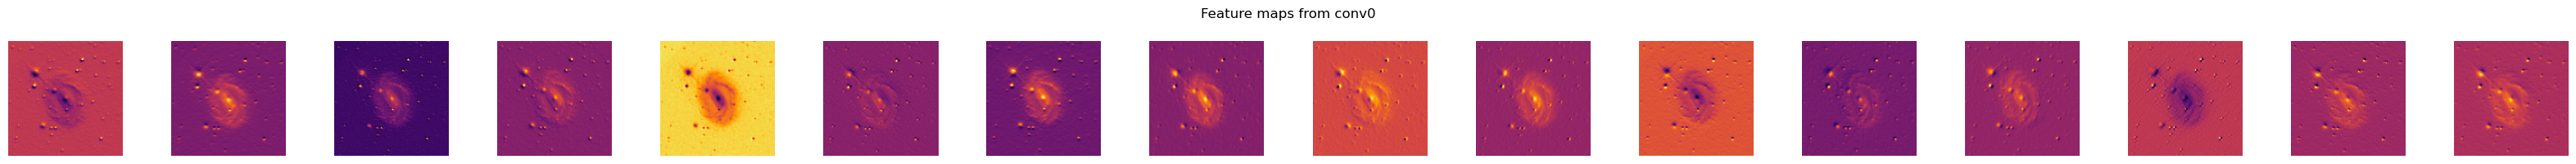

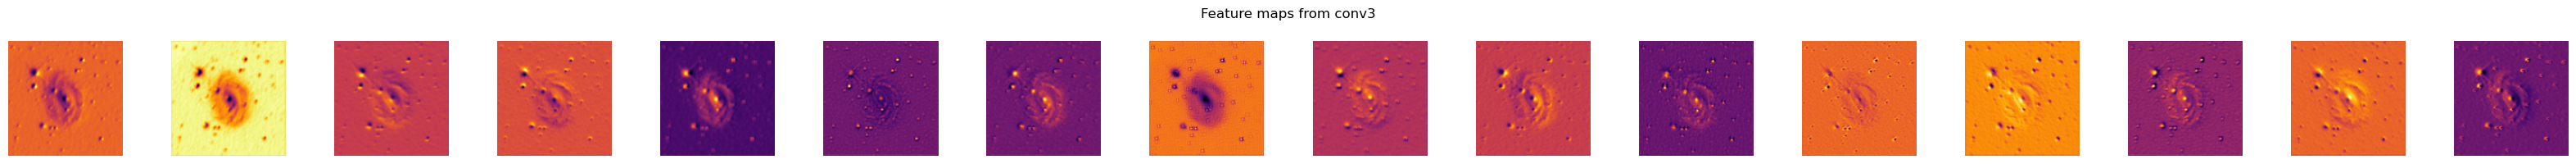

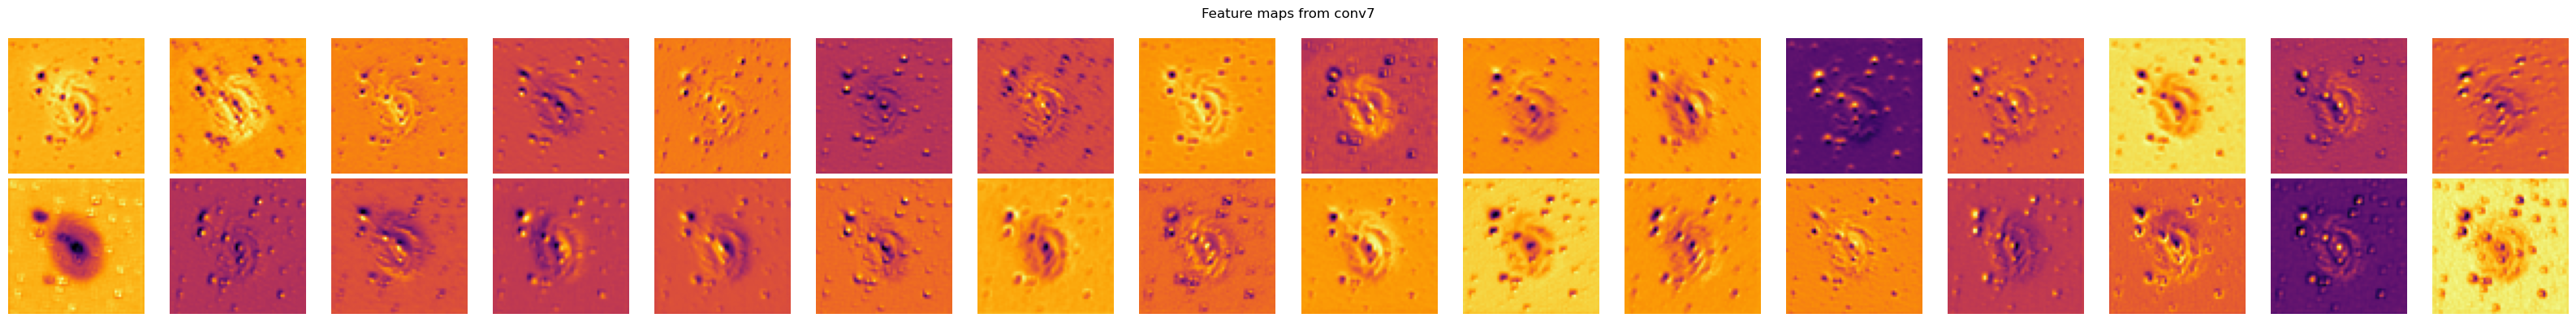

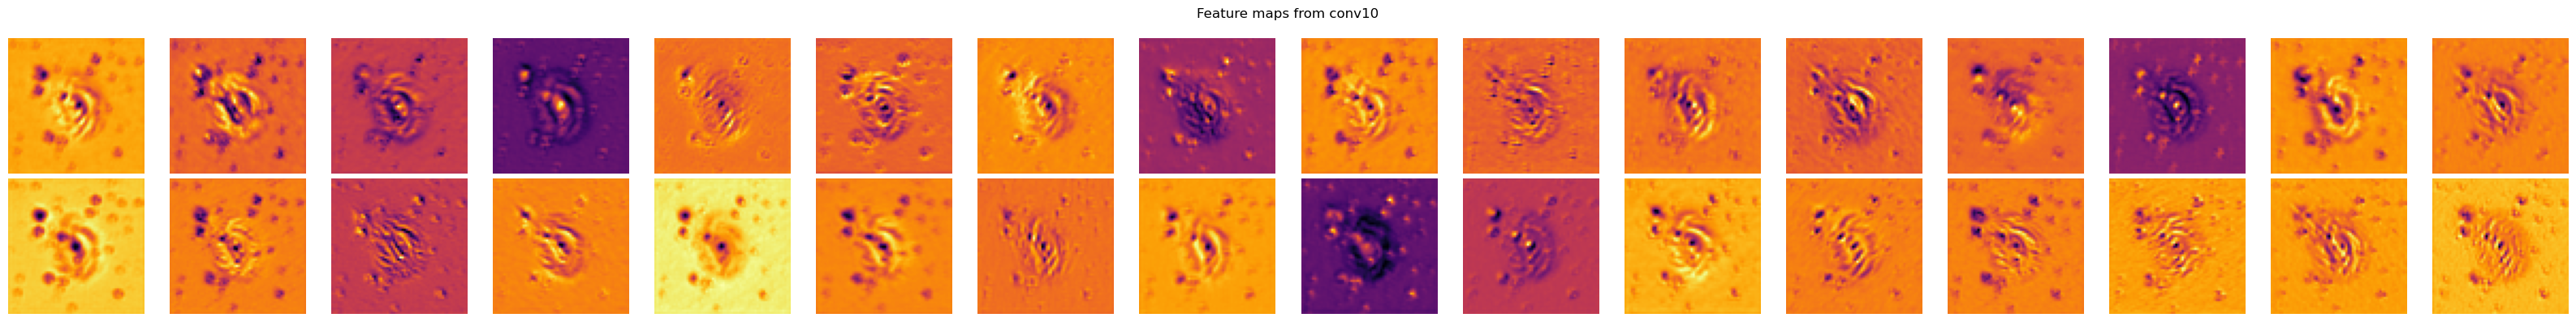

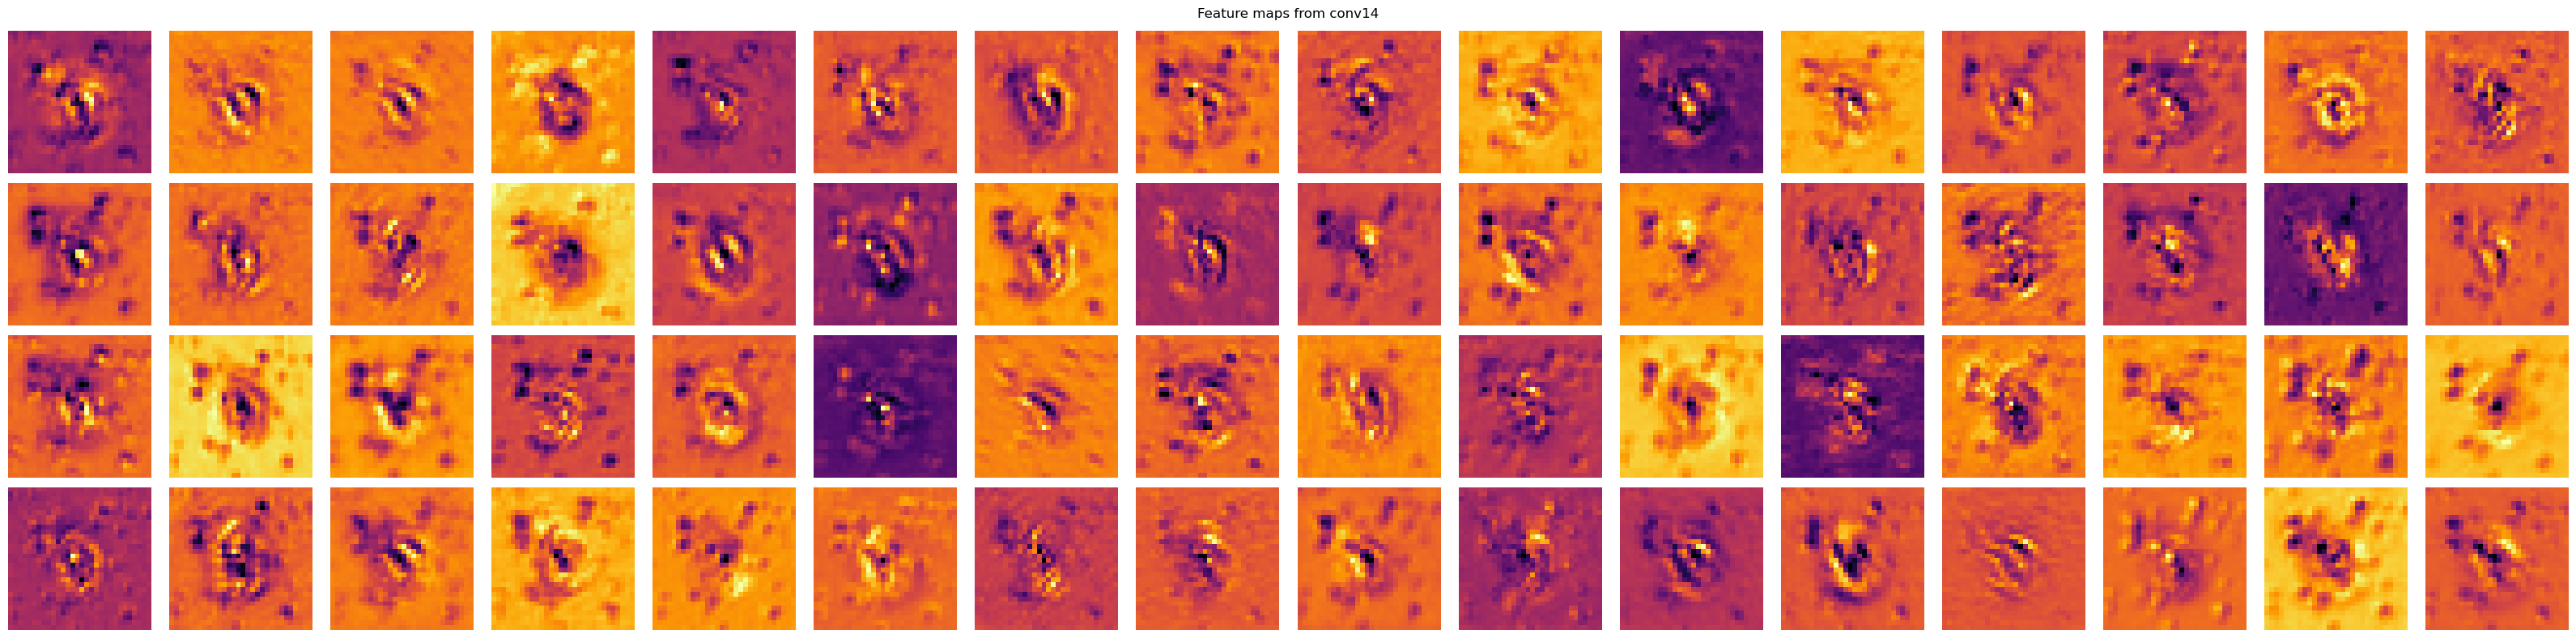

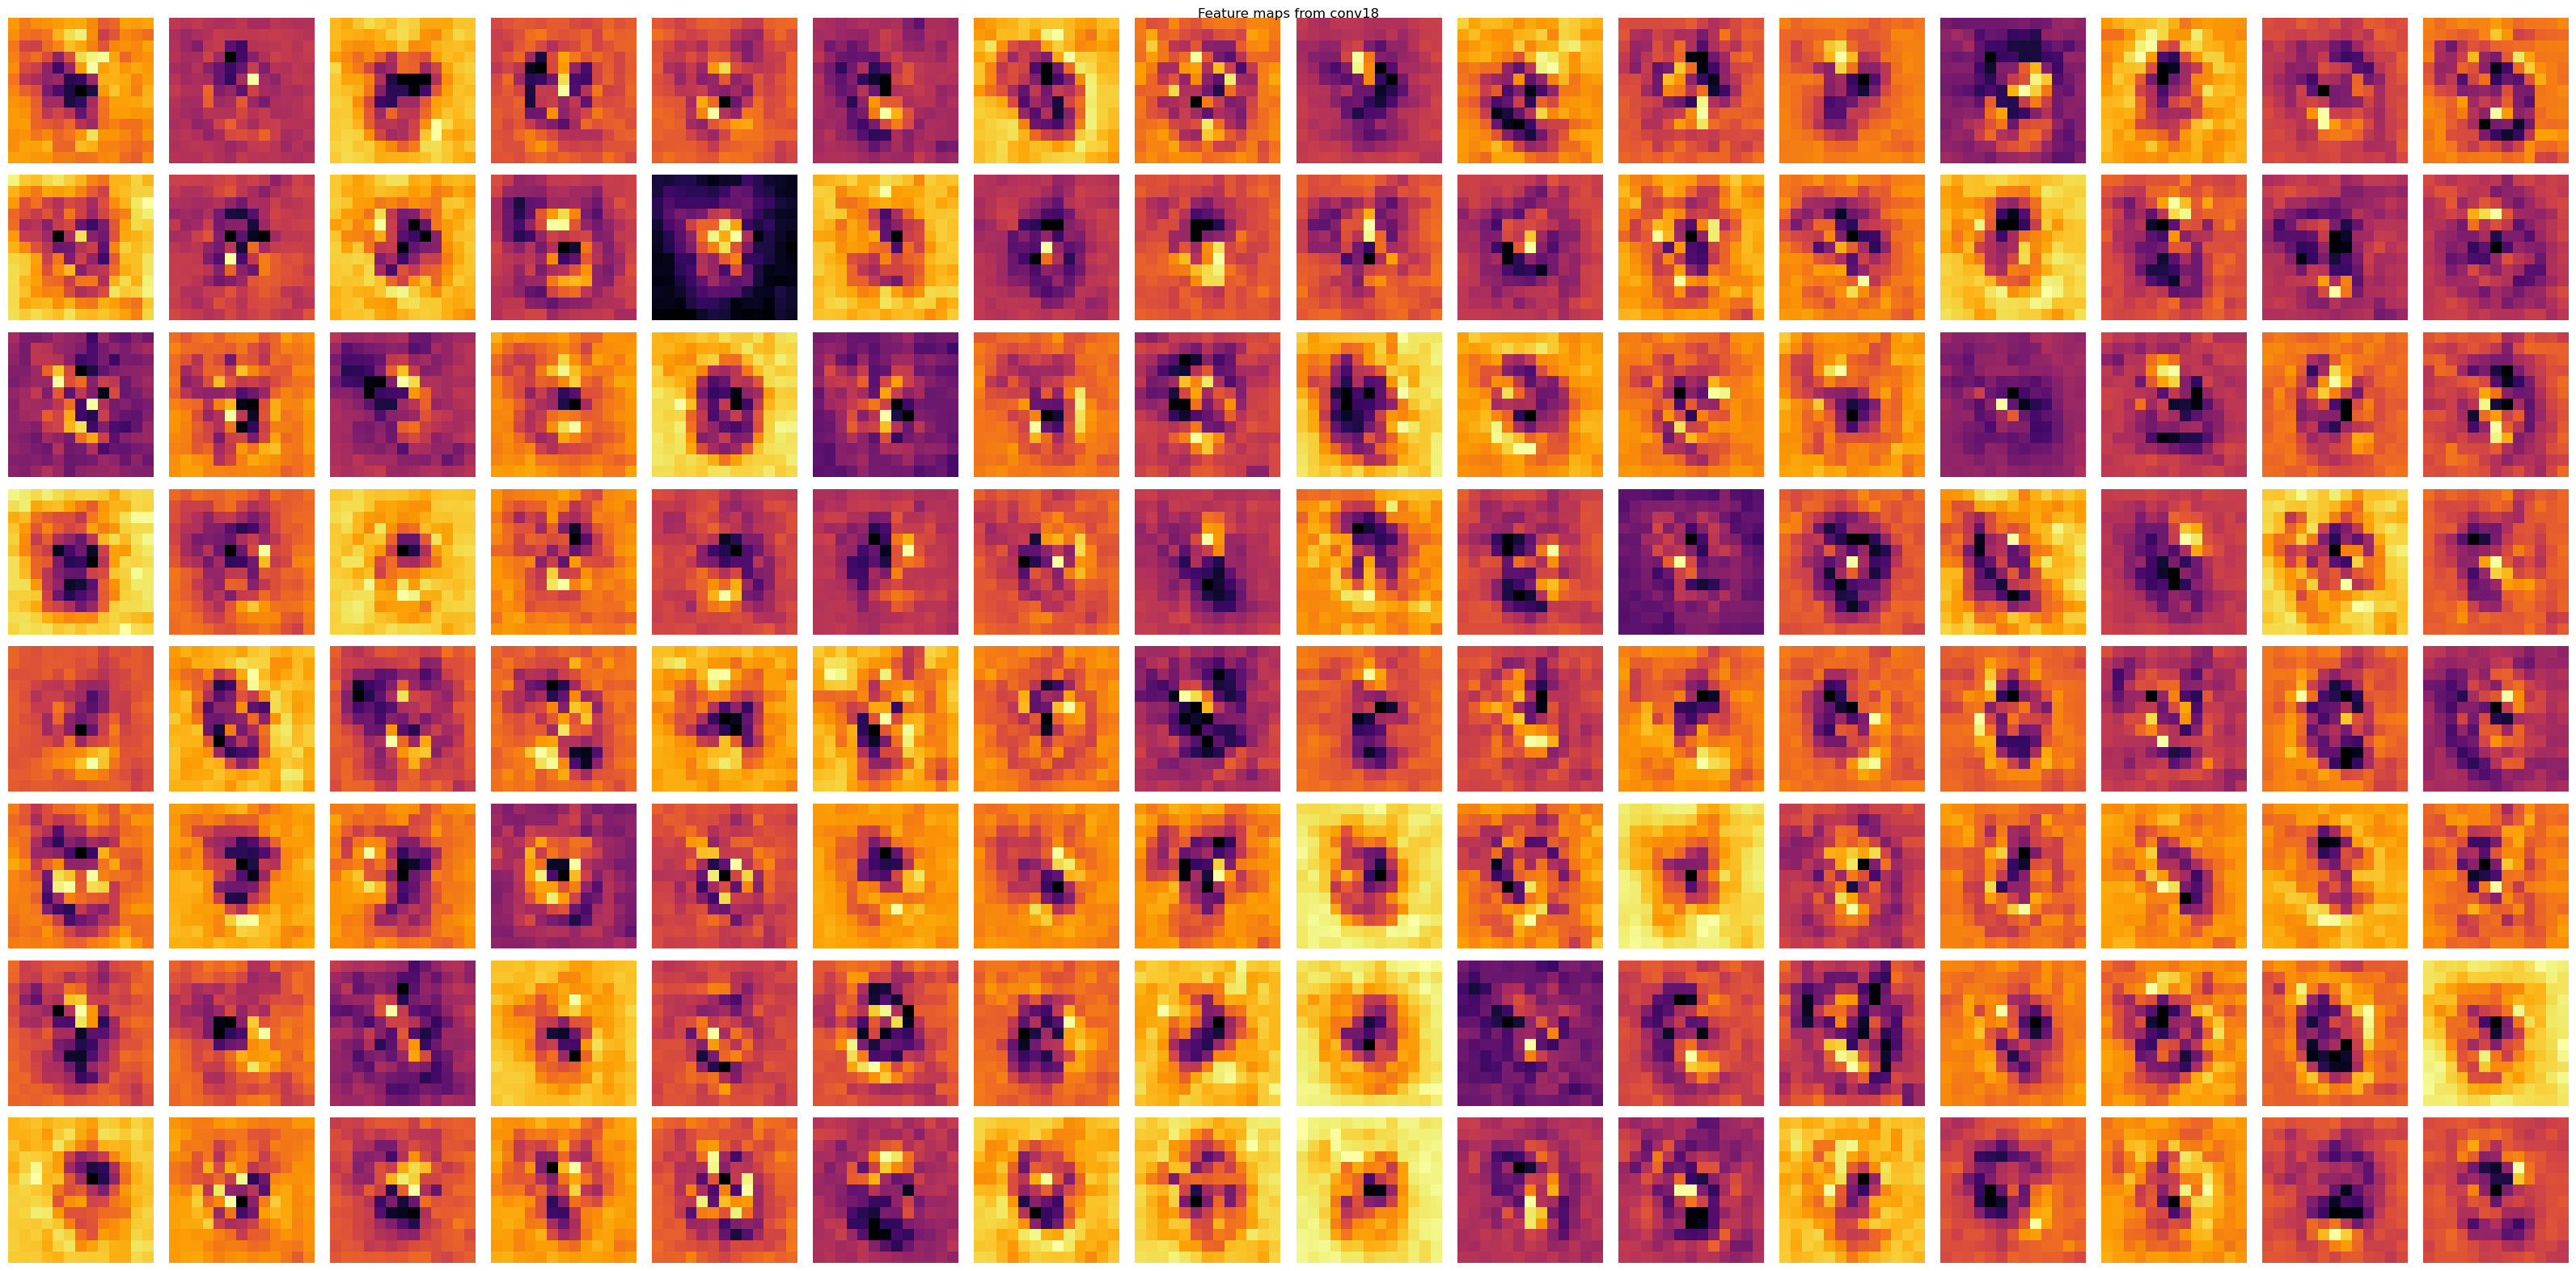

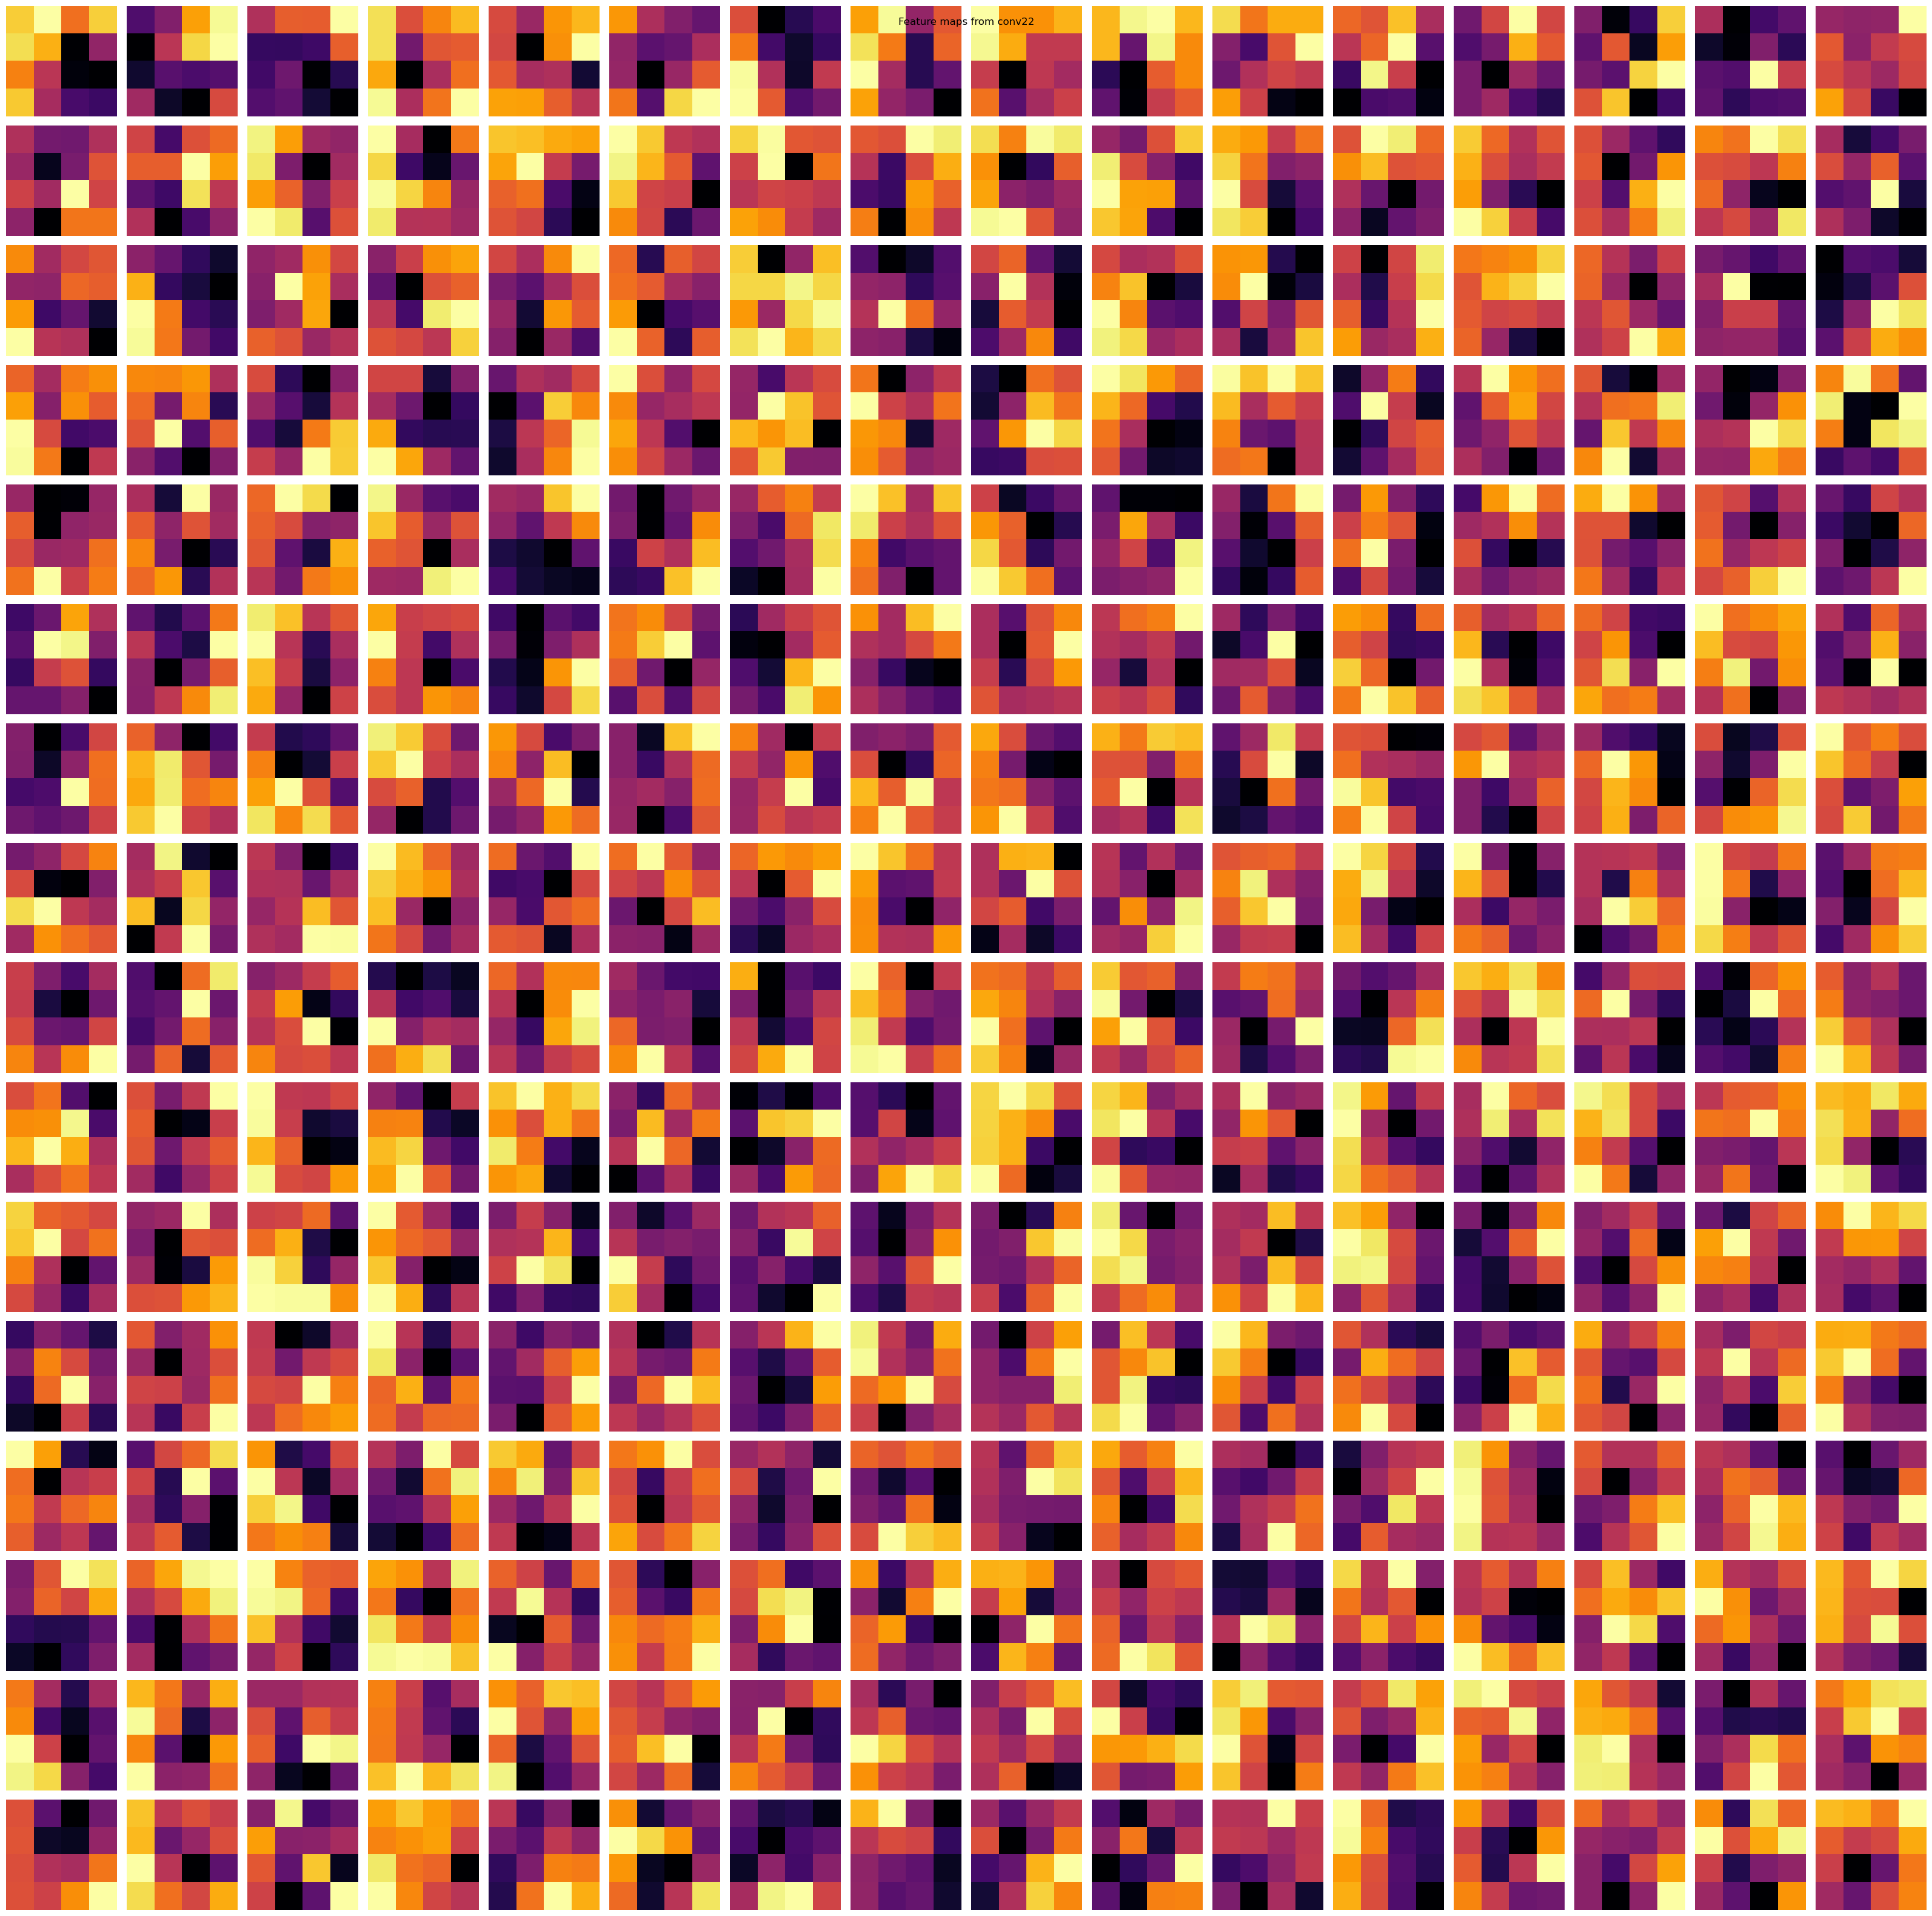

In [24]:

for i, layer in enumerate(model.convs):
    if isinstance(layer, torch.nn.Conv2d):
        model.convs[i].register_forward_hook(get_activation(f'conv{i}'))


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(324),
    transforms.Resize(128)
])

image = Image.open("../data/test/539989.jpg")
plt.imshow(image)
image = image.convert('L')
image = transform(image).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(image) 
 
for name, act in activations.items():
    plot_feature_maps(act, title=f"Feature maps from {name}")
